https://www.kaggle.com/code/onurkoc83/quantum-machine-learning-tutorial

In [2]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
iris = datasets.load_iris()

In [4]:
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)

In [5]:
Y_train

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1])

In [6]:
X_train[0]

array([5.2, 3.4, 1.4, 0.2])

In [7]:
print(X_train[0])

[5.2 3.4 1.4 0.2]


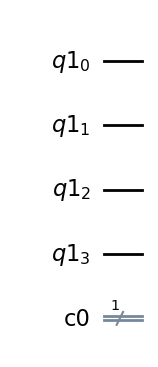

In [8]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

qc.draw("mpl")

the rx refers to the RX gate in Qiskit, which is a single-qubit rotation gate applied to a quantum circuit (qc). Specifically, it rotates the qubit’s state around the X-axis of the Bloch sphere by an angle specified by the parameter x.  X is the Pauli-X matrix.

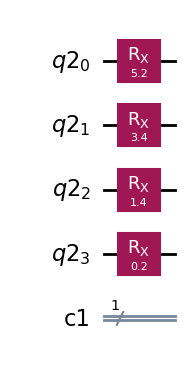

In [9]:
N=4
q = QuantumRegister(N)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)

for i, x in enumerate(X_train[0]):
    qc.rx(x, i)

qc.draw("mpl")

In [10]:
N=4
def feature_map(X):

    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)

    for i, x in enumerate(X):
        qc.rx(x, i)
    return qc, c 

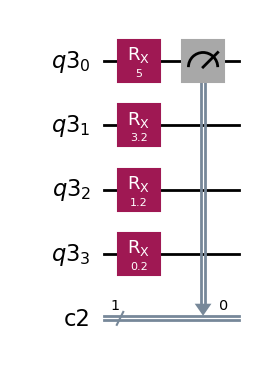

In [11]:
qc, c =feature_map(X_train[5])


# measurement operator
qc.measure(0,c)

qc.draw("mpl")

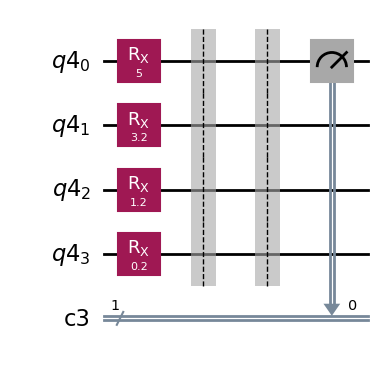

In [12]:
qc, c =feature_map(X_train[5])

qc.barrier()

qc.barrier()

# measurement operator
qc.measure(0,c)

qc.draw("mpl")

In [13]:
print(Y_train[5])

0


Variational Circuits

In [15]:
def variational_circuit(qc, theta):
    N = qc.num_qubits  # Get the number of qubits directly from the circuit

    # Apply CNOT gates between adjacent qubits (Linear Entangler)
    for i in range(N - 1):
        # Correct: use qc.cx() instead of qc.cnot()
        qc.cx(i, i + 1)

    # Apply CNOT gate from the last to the first qubit (Periodic Entangler)
    # Correct: use qc.cx() instead of qc.cnot()
    qc.cx(N - 1, 0)
    
    # Apply RY rotation to every qubit
    for i in range(N):
        qc.ry(theta[i], i)
        
    return qc

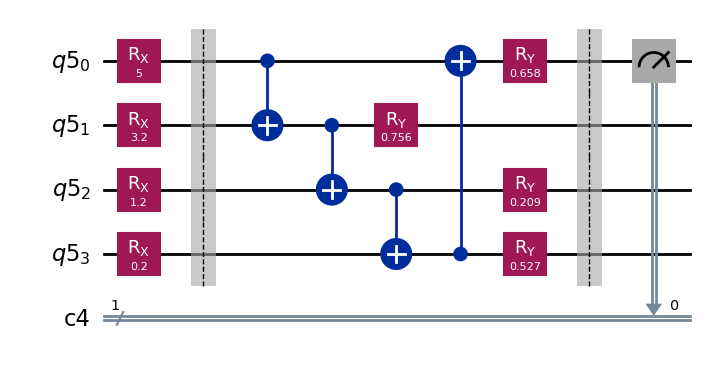

In [16]:
import numpy as np
qc, c =feature_map(X_train[5])

qc.barrier()

qc = variational_circuit(qc, np.random.rand(N))

qc.barrier()

# measurement operator
qc.measure(0,c)

qc.draw("mpl")

Blue line are circuits not gates. they create entanglement, so they essentially allow information to travel from one qubit to another

In [17]:
print(Y_train[5])

0


In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator

def quantum_nn(X, theta, simulator=True):
    qc, c = feature_map(X)  # Assuming feature_map returns a QuantumCircuit and classical register
    qc = variational_circuit(qc, theta)  # Assuming variational_circuit modifies qc
    qc.measure(0, c)

    shots = int(1e4)  # 10,000 shots
    if simulator:
        # Local simulation with AerSimulator
        backend = AerSimulator()
        result = backend.run(qc, shots=shots).result()
    else:
        # Optional: Cloud simulation or real hardware
        from qiskit_ibm_runtime import QiskitRuntimeService
        service = QiskitRuntimeService(name='Paul')
        backend = service.backend('ibm_brisbane')
        result = service.run(backend=backend.name, circuits=qc, shots=shots).result()

    counts = result.get_counts(qc)
    return counts.get("1", 0) / shots  # Return 0 if "1" not in counts

In [21]:
prediction = quantum_nn(X_train[5], np.random.rand(N))
prediction

0.6485

In [22]:
target = Y_train[5]
target

np.int64(0)

In [23]:
(target - prediction)**2

np.float64(0.42055224999999996)

In [24]:
def loss(prediction, target):
      return (target - prediction)**2

In [25]:
loss(prediction, target)

np.float64(0.42055224999999996)

Stochastic gradient descent rule:
 - minimize loss function
 - loop over training data
 - update variational parameters 
 - use loss function to update theta

In [26]:
import copy

def gradient(X, Y, theta):
    
      delta = 0.01

      grad = []
    
      for i in range(len(theta)):

          dtheta = copy.copy(theta)  # shallow copy
          dtheta[i] += delta

          pred1 = quantum_nn(X, dtheta)
          pred2 = quantum_nn(X, theta)
          # finite difference
          grad.append( (loss(pred1, Y)-loss(pred2, Y))/ delta)

      return np.array(grad)

In [27]:
import copy

# Original list with nested list
original = [1, [2, 3], 4]

# Shallow copy
shallow = copy.copy(original)
shallow[1][0] = 99  # Modifies nested list in both original and shallow
print(original)  # Output: [1, [99, 3], 4]
print(shallow)   # Output: [1, [99, 3], 4]

# Deep copy
deep = copy.deepcopy(original)
deep[1][0] = 100  # Modifies only deep's nested list
print(original)  # Output: [1, [99, 3], 4]
print(deep)      # Output: [1, [100, 3], 4]

[1, [99, 3], 4]
[1, [99, 3], 4]
[1, [99, 3], 4]
[1, [100, 3], 4]


In [28]:
def accuracy(X, Y, theta):

      counter = 0
      for X_i, Y_i in zip(X, Y):

          prediction = quantum_nn(X_i, theta)

          if prediction < 0.5 and Y_i == 0:
               counter +=1
          elif prediction >= 0.5 and Y_i == 1:
               counter +=1
      return counter/len(Y)

In [29]:
eta = 0.05 

loss_list = []
theta = np.ones(N)

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(20):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))

        # update theta,gradient descent rule
        theta = theta - eta * gradient(X_i, Y_i, theta)
    
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.286 	 0.179
1 	 0.275 	 0.209
2 	 0.262 	 0.597
3 	 0.234 	 0.791
4 	 0.243 	 0.806
5 	 0.246 	 0.254
6 	 0.248 	 0.761
7 	 0.240 	 0.806
8 	 0.246 	 0.806
9 	 0.231 	 0.806
10 	 0.228 	 0.836
11 	 0.213 	 0.836
12 	 0.217 	 0.821
13 	 0.223 	 0.821
14 	 0.225 	 0.746
15 	 0.232 	 0.836
16 	 0.215 	 0.821
17 	 0.206 	 0.851
18 	 0.204 	 0.881
19 	 0.200 	 0.866


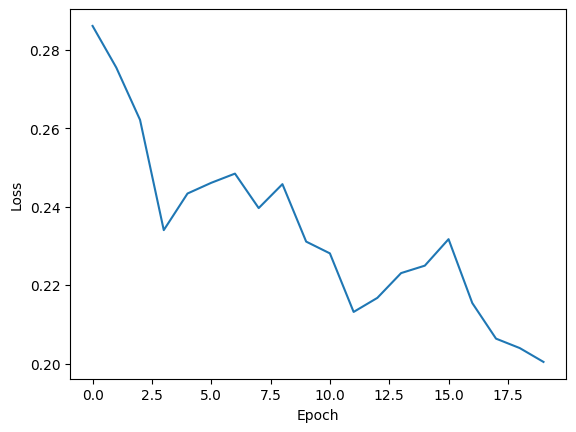

In [30]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [31]:
accuracy(X_test, Y_test, theta)

0.7575757575757576

In [32]:
clf = svm.SVC()
clf.fit(X_train, Y_train)

print(clf.predict(X_test))
print(Y_test)

[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1]
